In [4]:
import pandas as pd

df = pd.read_csv('../data/simulated_auto_sales.csv')
print(df.columns)
print(df.head())

Index(['Date', 'Total_Sales'], dtype='object')
      Date  Total_Sales
0  2018-01       246863
1  2018-01       262123
2  2018-03       257477
3  2018-04       254954
4  2018-05       244577


Auto Sales:
             Total_Sales
Date                   
2018-01-01       246863
2018-01-01       262123
2018-03-01       257477
2018-04-01       254954
2018-05-01       244577
Cleaned CPI:
              CPI
Month           
2018-01-01  5.07
2018-02-01  4.44
2018-03-01  4.28
2018-04-01  4.58
2018-05-01  4.87
RBI Rates:
             Repo Reverse_Repo
Date                         
2022-12-31  6.25         None
2023-01-31  6.25         None
2023-02-28  6.50         None
2023-03-31  6.50         None
2023-04-30  6.50         None

Merged Data Preview:
            Total_Sales   CPI  Repo  Reverse_Repo
2024-10-31      62235.0  6.21  6.25           NaN
2024-11-01      62235.0  5.48  6.25           NaN
2024-11-30      62235.0  5.48  6.25           NaN
2024-12-01      62235.0  5.22  6.25           NaN
2024-12-31      62235.0  5.22  6.50           NaN
Total_Sales     float64
CPI              object
Repo            float64
Reverse_Repo    float64
dtype: object
Total_Sales    float64
CPI      

/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/var/folders/vq/67rg32y9779bptdgz21w4ql80000gn/T/ipykernel_32486/2006910272.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cpi['Month'] = pd.to_datetime(cpi['Month'], format='%b-%Y', errors='coerce')
/var/folders/vq/67rg32y9779bptdgz21w4ql80000gn/T/ipykernel_32486/2006910272.py:37: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  rbi_rates = rbi_rates.resample('M').ffill()
/var/folders/vq/67rg32y9779bptdgz21w4ql80000gn/T/ipykernel_324

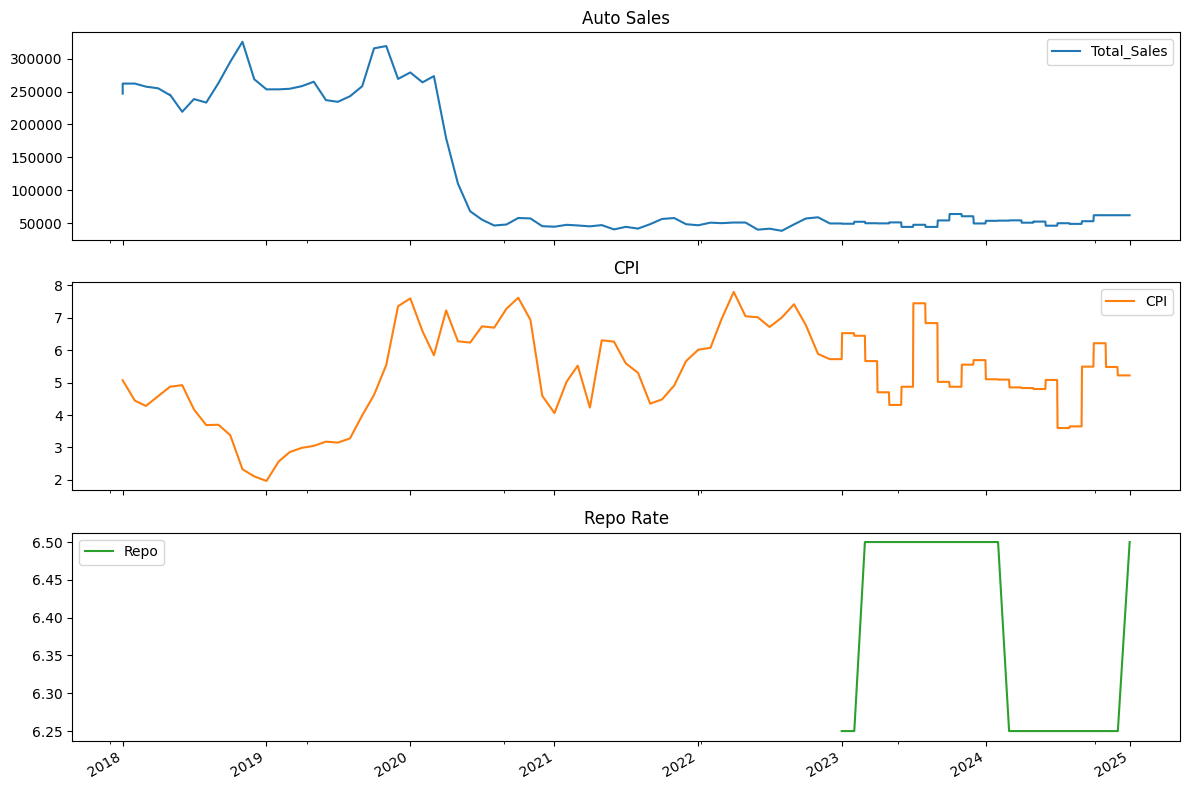

In [14]:
# Phase 1: Data Cleaning and Standardization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1. Load Auto Sales CSV
auto_sales = pd.read_csv('../data/simulated_auto_sales.csv', parse_dates=['Date'])
auto_sales = auto_sales.sort_values('Date')
auto_sales.set_index('Date', inplace=True)
print("Auto Sales:\n", auto_sales.head())


# 2. Load Consumer Price Index (Excel)
# Reload CPI file using correct headers
cpi_raw = pd.read_excel('../data/RBIB Table No. 18 _ Consumer Price Index (Base 2010=100).xlsx', skiprows=6, header=None)

# Keep relevant columns: Month and Combined Index
cpi = cpi_raw[[1, 9]]
cpi.columns = ['Month', 'CPI']
cpi['Month'] = pd.to_datetime(cpi['Month'], format='%b-%Y', errors='coerce')
cpi = cpi.dropna()
cpi = cpi.set_index('Month').sort_index()
cpi = cpi.ffill()

print("Cleaned CPI:\n", cpi.head())


# 3. Parse PDF Monetary Policy Rates (manually transcribed sample)
repo_data = {
    'Date': ['2024-12-14', '2024-02-07', '2023-02-08', '2022-12-07'],
    'Repo': [6.50, 6.25, 6.50, 6.25],
    'Reverse_Repo': [None, None, None, None]  # as values not clearly given
}
rbi_rates = pd.DataFrame(repo_data)
rbi_rates['Date'] = pd.to_datetime(rbi_rates['Date'])
rbi_rates.set_index('Date', inplace=True)
rbi_rates = rbi_rates.resample('M').ffill()
print("RBI Rates:\n", rbi_rates.head())

# 4. Merge all datasets into a single monthly frame
merged = auto_sales.join(cpi, how='outer').join(rbi_rates, how='outer')
merged = merged.sort_index()
merged = merged.ffill()
print("\nMerged Data Preview:")
print(merged.tail())

print(merged.dtypes)

merged['CPI'] = pd.to_numeric(merged['CPI'], errors='coerce')

# Double check all three columns are numeric now
print(merged[['Total_Sales', 'CPI', 'Repo']].dtypes)


# 5. Plot to visually inspect trends
merged[['Total_Sales', 'CPI', 'Repo']].plot(
    subplots=True, figsize=(12, 8), 
    title=['Auto Sales', 'CPI', 'Repo Rate']
)
plt.tight_layout()
plt.show()

# 6. Save cleaned file
merged.to_csv('../data/cleaned_macro_data.csv')


In [15]:
import os
os.makedirs('../outputs', exist_ok=True)

# Save cleaned CPI
cpi.to_csv('../outputs/cleaned_cpi.csv')

# Save cleaned auto sales
auto_sales.to_csv('../outputs/cleaned_auto_sales.csv')

# Save cleaned/merged macro data
merged.to_csv('../outputs/cleaned_macro_data.csv')

# Save plots
plt.figure(figsize=(12, 6))
merged['Total_Sales'].plot(title='Auto Sales Trend')
plt.ylabel("Units")
plt.tight_layout()
plt.savefig('../outputs/plot_auto_sales_trend.png')
plt.close()

plt.figure(figsize=(12, 6))
merged['CPI'].astype(float).plot(title='CPI Trend')
plt.ylabel("CPI (%)")
plt.tight_layout()
plt.savefig('../outputs/plot_cpi_trend.png')
plt.close()

plt.figure(figsize=(12, 6))
merged['Repo'].plot(title='Repo Rate Trend')
plt.ylabel("Repo Rate (%)")
plt.tight_layout()
plt.savefig('../outputs/plot_repo_trend.png')
plt.close()
